# Multi-Class-Classification-with-MobileNetV2-for-Pathogen-Detection

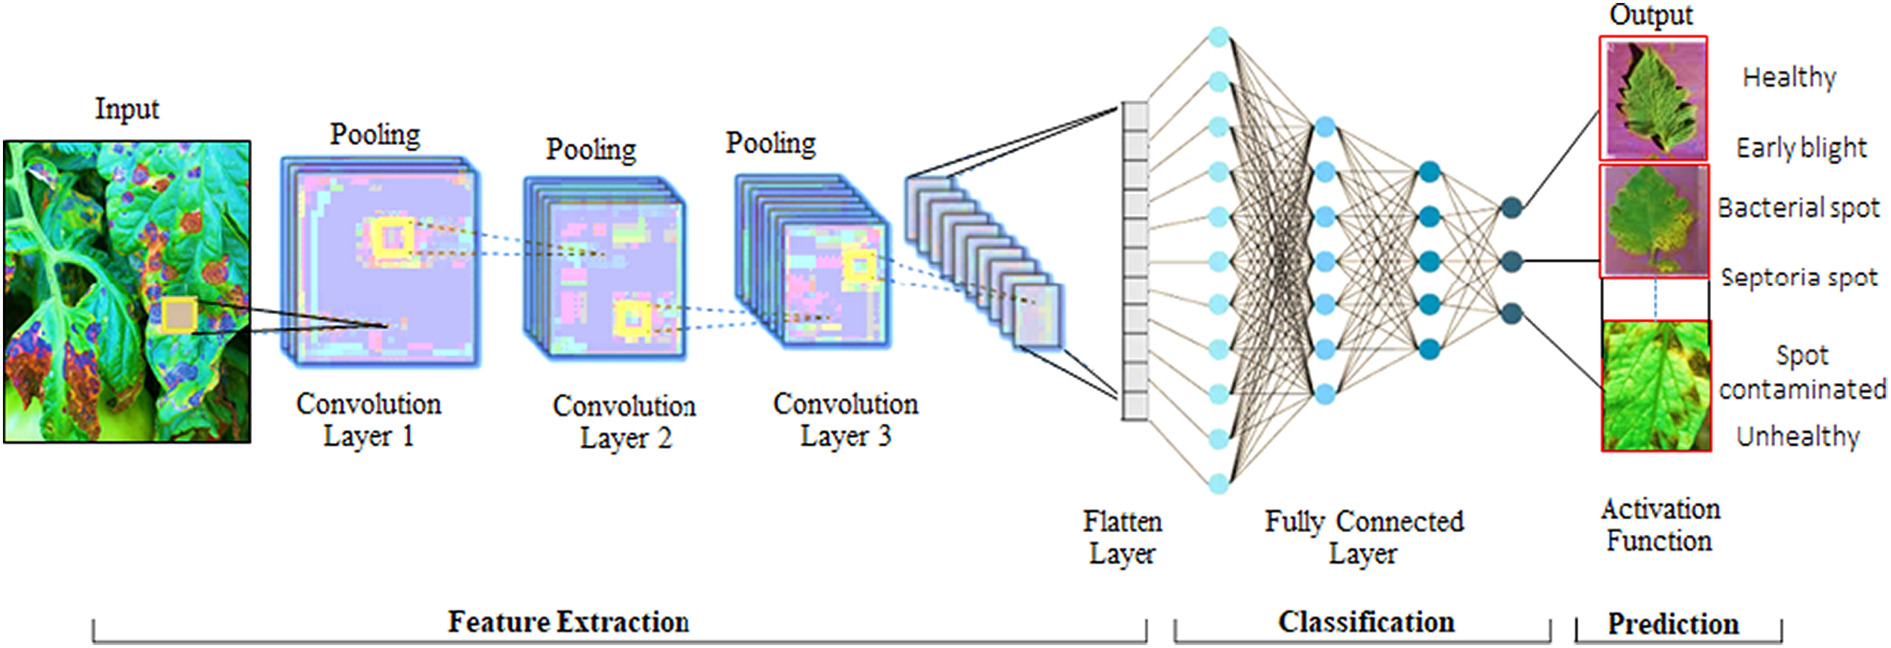

## 🚀 Transfer Learning with MobileNetV2 on Plant Pathogen Dataset 🌱

I recently completed a transfer learning project utilizing the MobileNetV2 model pre-trained on ImageNet weights to classify plant diseases in the Plant Pathogen Classification Dataset. This dataset includes images of plant diseases caused by fungi, bacteria, viruses, pests, and a separate class of healthy leaves. It provides valuable insights for researchers and practitioners in plant pathology and agriculture.


## 📊 Model Performance:

 ### **Accuracy: 89.4% on test data**
#### Precision, Recall & F1-Score:
* Bacteria: Precision = 0.94, Recall = 0.83, F1-Score = 0.88
* Fungi: Precision = 0.93, Recall = 0.95, F1-Score = 0.94
* Healthy: Precision = 0.88, Recall = 0.90, F1-Score = 0.89
* Pests: Precision = 0.83, Recall = 0.92, F1-Score = 0.88
* Virus: Precision = 0.90, Recall = 0.87, F1-Score = 0.89

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kanishk3813/pathogen-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pathogen-dataset


In [3]:
train_data='/kaggle/input/pathogen-dataset/pathogen'

In [ ]:
import pathlib as path
train_img=path.Path(train_data)
train_img

In [4]:
import os
import shutil
import random

# Set the paths
source_folder = train_data  # Your main folder with 5 class folders
train_folder = '/kaggle/working/train-data'  # Output folder for train split
test_folder = '/kaggle/working/test-data'   # Output folder for test split
split_ratio = 0.8                        # Percentage of data to go into the train set

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Iterate over each class folder in the source directory
for class_folder in os.listdir(source_folder):
    class_path = os.path.join(source_folder, class_folder)

    # Skip the 'pathogen' folder itself
    if not os.path.isdir(class_path) or class_folder == 'pathogen':
        continue  # Skip if it's not a directory or is the main folder itself

    # List all files in the class folder and shuffle them
    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(files)

    # Calculate split index
    split_index = int(len(files) * split_ratio)

    # Separate files for train and test
    train_files = files[:split_index]
    test_files = files[split_index:]

    # Create class folders in train and test folders
    train_class_path = os.path.join(train_folder, class_folder)
    test_class_path = os.path.join(test_folder, class_folder)
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # Move the files to the respective folders
    for file in train_files:
        shutil.copy(os.path.join(class_path, file), train_class_path)

    for file in test_files:
        shutil.copy(os.path.join(class_path, file), test_class_path)

print("Data split completed successfully.")


Data split completed successfully.


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    image_size=(224, 224),  # Resize images to 256x256
    batch_size=32,          # Batch size
    label_mode='int',       # 'int' for integer labels, 'categorical' for one-hot encoding
    seed=123,               # Random seed for shuffling the data
    validation_split=0.2,   # Split 20% for validation
    subset="training"       # Use this subset for training
)

Found 31997 files belonging to 5 classes.
Using 25598 files for training.


In [6]:
dataset.class_names

['Bacteria', 'Fungi', 'Healthy', 'Pests', 'Virus']

In [7]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    seed=123,

    validation_split=0.2,
    subset="validation"
)

Found 31997 files belonging to 5 classes.
Using 6399 files for validation.


In [8]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    seed=123
)

Found 8000 files belonging to 5 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load MobileNetV2 from keras.applications, not keras.preprocessing
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),  # Image size expected by MobileNetV2
    include_top=False,          # Exclude the top classification layer
    weights='imagenet'          # Load pre-trained ImageNet weights
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
import tensorflow
def process(image,label):
    image = tensorflow.cast(image/224 ,tensorflow.float32)
    return image,label

# test_ds = test_folder.map(process)
# val_dataset = validation_dataset.map(process)

In [11]:
base_model.trainable = False

In [12]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),   # Define input shape explicitly
    base_model,                          # Frozen MobileNetV2 base model
    layers.Dropout(0.1),                 # Dropout layer
    layers.GlobalAveragePooling2D(),     # Reduce spatial dimensions
    layers.Dense(128, activation='relu'), # New dense layer with 128 units
    layers.Dense(5, activation='softmax') # Output layer for 5 classes
])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Train the model
history=model.fit(dataset, validation_data=validation_dataset, epochs=7)

Epoch 1/7


I0000 00:00:1731341666.314308     126 service.cc:145] XLA service 0x782a28005ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731341666.314384     126 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731341666.314391     126 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/800 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.1857 - loss: 2.1245 

I0000 00:00:1731341674.686525     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


800/800 ━━━━━━━━━━━━━━━━━━━━ 53s 49ms/step - accuracy: 0.7483 - loss: 0.7090 - val_accuracy: 0.8781 - val_loss: 0.3633
Epoch 2/7
800/800 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.8815 - loss: 0.3426 - val_accuracy: 0.8814 - val_loss: 0.3306
Epoch 3/7
800/800 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8966 - loss: 0.2924 - val_accuracy: 0.9025 - val_loss: 0.2783
Epoch 4/7
800/800 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.9168 - loss: 0.2424 - val_accuracy: 0.8889 - val_loss: 0.3335
Epoch 5/7
800/800 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.9196 - loss: 0.2266 - val_accuracy: 0.8987 - val_loss: 0.2912
Epoch 6/7
800/800 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.9263 - loss: 0.2081 - val_accuracy: 0.9048 - val_loss: 0.2765
Epoch 7/7
800/800 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.9356 - loss: 0.1871 - val_accuracy: 0.9237 - val_loss: 0.2256


In [16]:
history.history['accuracy']

[0.821548581123352,
 0.8856551051139832,
 0.9020236134529114,
 0.9187045693397522,
 0.9242128133773804,
 0.9289788007736206,
 0.9379639029502869]

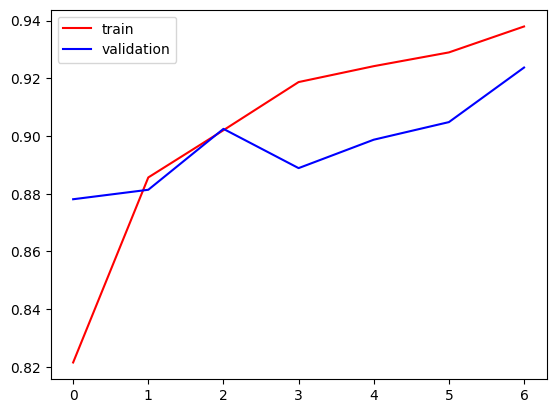

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()

plt.show()

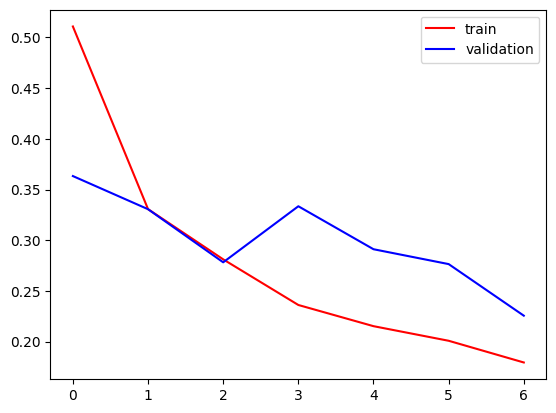

In [18]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [19]:
# Evaluate the model on the validation dataset
subset_dataset=test_dataset.take(5000)
test_loss, test_accuracy = model.evaluate(subset_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9350 - loss: 0.1919
Test Loss: 0.19285918772220612
Test Accuracy: 0.9359999895095825


In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Define class names corresponding to the indices
class_names = ['Bacteria', 'Fungi', 'Healthy', 'Pests', 'Virus']

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_classes = []

# Loop over the test dataset to get predictions and true labels
for images, labels in test_dataset:
    # Predict on each batch
    predictions = model.predict(images)
    predicted_classes.extend(np.argmax(predictions, axis=1))  # Use np.argmax on predictions

    # Use labels directly if they are already class indices
    true_labels.extend(labels)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_classes = np.array(predicted_classes)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_classes)
print(f"Accuracy: {accuracy}")

# Print classification report for precision, recall, and F1-score
print("Classification Report:")
print(classification_report(true_labels, predicted_classes, target_names=class_names))





1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━

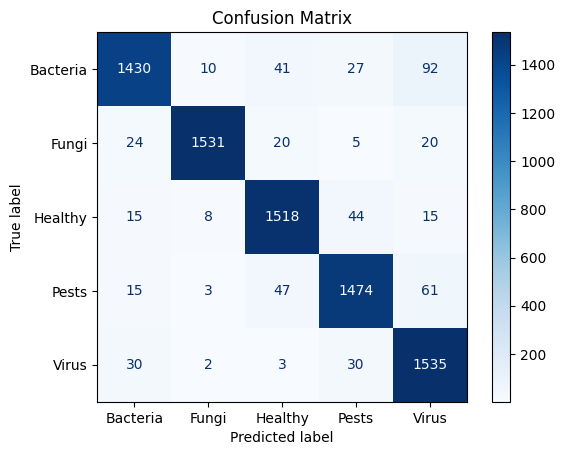

In [21]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Display confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
